# Análise de sentimentos

## Introdução

Esse notebook tem como objetivo realizar análise de sentimento em comentários de clientes de lojas virtuais, oferecidos pela B2W Digital (grupo responsável pelas lojas Submarino, Shoptime e Americanas.com), classificando-os como "Positivos", "Neutros" ou "Negativos", para compor um painel online de de informações e insights sobre a satisfação desses clientes por estado/região do Brasil, construindo assim, uma ferramenta de análise poderosa.
Para isso, aqui vamos usar uma biblioteca de machine learning (aprendizado de máquina) chamada XGBoost, e especificamente o modelo XGBClassifier.
Neste notebook teremos textos explicativos, códigos do projeto realizado e gráficos para análise de resultados.

## Índice
* [Machine Learning](#machine-learning)
* [Base de dados](#base-de-dados)
* [Principais Bibliotecas (e importação delas)](#principais-bibliotecas)
* [Tratamento da base](#tratamento-da-base)
    * [Limpeza inicial](#limpeza-inicial)
    * [Classificação de comentários](#classificação-de-comentários)
    * [Pré-processamento do texto](#pré-processamento-do-texto)
    * [Sepração de dados](#separação-de-dados)
    * [Vetorização](#vetorização)
* [Balanceamento de classes](#balanceamento-de-classes)
* [Treinamento de validação do modelo](#treinamento-e-validação-do-modelo)
* [Resultados]()
    * [Acurácia]()
    * [Previsão das classes]()
    * [Matriz de confusão](#matriz-de-confusão)
    * [Avaliação de performance](#avaliação-de-performance)
    * [Curva de ROC](#curva-de-roc)
* [Exportação do modelo](#exportação-do-modelo)


## Machine Learning
Como dito anteriormente, para realizar nosso aprendizado de máquina e conseguir fazer a análise de sentimento dos comentários, optamos por utilizar o CatBoost. Aqui estão alguns motivos que guiaram a escolha dessa tecnologia:

1- Desempenho: conhecido por sua capacidade de fornecer um desempenho excepcional em uma ampla gama de conjuntos de dados. Ele é altamente otimizado e eficiente, o que o torna uma escolha ideal para lidar com grandes conjuntos de dados com muitas características.

2- Regularização: oferece várias técnicas de regularização, como regularização L1 e L2, que ajudam a evitar overfitting e melhorar a generalização do modelo. Isso é especialmente importante em análise de sentimentos, onde o sobreajuste pode ser um problema comum devido à complexidade e subjetividade dos dados.

3- Flexibilidade: suporta uma variedade de funções de perda e métricas de avaliação, permitindo que você ajuste o modelo de acordo com os requisitos específicos do problema de análise de sentimentos. Além disso, ele pode ser facilmente integrado com outras bibliotecas e ferramentas populares de ciência de dados.

4- Interpretabilidade: embora seja um modelo complexo, XGBoost oferece certa interpretabilidade. Você pode visualizar a importância das características, o que ajuda a entender quais palavras ou características estão contribuindo mais para as previsões de sentimento.

## Base de dados
Está disponível em [b2w-reviews01](https://github.com/americanas-tech/b2w-reviews01) e contém mais de 130 mil linhas de avaliações de clientes sobre produtos adquiridos no site Americanas.com.
Essa base conta com diversas informações, entre as mais importantes para nós estão a avaliação em comentário, a nota que reflete a satisfacação do cliente com base na compra feita e o estado do cliente que avaliou. Além disso também temos mais informações do produto como categoria, marca etc, mais informações pessoais dos clientes como sexo, ano de nascimento etc, um complemento ao nível de satisfação com informação de possível indicação dos produtos, e claro, data das avaliações realizadas.

## Principais Bibliotecas

### XGBoost
XGBoost (eXtreme Gradient Boosting) é uma biblioteca de código aberto, amplamente utilizada em machine learning devido à sua eficiência e alto desempenho. Projetada para ser rápida e flexível, ela emprega técnicas avançadas de árvore de decisão para melhorar a precisão dos modelos. Em nosso projeto, estamos utilizando XGBoost para realizar a análise de sentimento em comentários de review de produtos.

### Pandas
A biblioteca pandas é essencial para a manipulação e análise de dados. Ela oferece estruturas de dados flexíveis, como DataFrames, que são ideais para carregar, manipular e analisar grandes conjuntos de dados. No nosso projeto, pandas é utilizada para ler arquivos CSV, explorar os dados e realizar operações de limpeza e transformação.

### NLTK
O NLTK (Natural Language Toolkit) é uma biblioteca poderosa para processamento de linguagem natural (PLN). Ela inclui ferramentas para tokenização, stemming, lematização e remoção de stopwords, que são fundamentais para a preparação de dados textuais. No nosso contexto de análise de sentimentos, o nltk ajuda a transformar texto bruto em uma forma que pode ser analisada por algoritmos de machine learning.

### sklearn (scikit-learn)
A biblioteca scikit-learn é uma ferramenta robusta para machine learning em Python. Ela oferece vários módulos para dividir dados, criar modelos e avaliar sua performance. Neste projeto, scikit-learn é utilizada para:
* model_selection: nas ferramentas como train_test_split e StratifiedKFold para dividir os dados em conjuntos de treino e teste, e para realizar validação cruzada.
* feature_extraction.text: o CountVectorizer transforma texto em vetores de contagem de palavras, permitindo que dados textuais sejam usados por modelos de machine learning.
* metrics: nas funções como confusion_matrix, precision_score, recall_score, f1_score, roc_curve e auc para avaliar a performance do modelo.

### Matplotlib e seaborn
As bibliotecas matplotlib e seaborn são usadas para visualização de dados. Elas permitem criar gráficos e visualizações que ajudam a entender a distribuição dos dados e a performance do modelo. Especificamente, usamos:
* matplotlib.pyplot: ferramentas básicas para criação de gráficos 2D.
* seaborn: facilita a criação de gráficos estatísticos mais atraentes e informativos, ajudando na análise exploratória dos dados.

### Joblib
Essa biblioteca é utilizada para serializar e desserializar objetos Python, como modelos de machine learning treinados. Isso permite salvar um modelo treinado em disco e carregá-lo posteriormente para fazer previsões.

In [2]:
# Importação das bibliotecas utilizadas
import re
import string
import unicodedata
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from joblib import dump
from tabulate import tabulate
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import StratifiedKFold


# Baixa recursos necessários do NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ghans\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ghans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ghans\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Carregamento da base de dados
Vamos iniciar nosso código com o carregamento e leitura da base de dados pela biblioteca Pandas: 

In [3]:
# Carrega o conjunto de dados
dataset = pd.read_csv("C:\\fatec\\B2W-Reviews01\\B2W-Reviews01.csv")
dataset2 = pd.read_csv("C:\\fatec\\olist_order_reviews_dataset.csv")

# Mostra o tamanho do dataset original
print("Tamanho do dataset 1 original:", dataset.shape[0], "linhas,", dataset.shape[1], "colunas.")
print("Tamanho do dataset 2 original:", dataset2.shape[0], "linhas,", dataset2.shape[1], "colunas.")

C:\Users\ghans\AppData\Local\Temp\ipykernel_26548\1162152241.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("C:\\fatec\\B2W-Reviews01\\B2W-Reviews01.csv")


Tamanho do dataset 1 original: 132373 linhas, 14 colunas.
Tamanho do dataset 2 original: 99224 linhas, 7 colunas.


## Tratamento da base de dados
Aqui veremos uma série de etapas para limpar e tratar nossa base de dados, para que seja possível realizar um treinamento efetivo do modelo com ela.

### Limpeza inicial

Estamos usando a já mencionada biblioteca Pandas, para fazer a leitura da nossa base, que está em formato CSV. Após isso, removemos as linhas com valores nulos nas colunas de comentário (review_text) e nota da avaliação (overall_rating), pois apenas essas serão utilizadas no treinamento.

In [32]:
# Remove linhas com valores em branco
dataset = dataset.dropna(subset=['review_text', 'overall_rating'])
dataset2 = dataset2.rename(columns={'review_comment_message' : 'review_text','review_score' : 'overall_rating'})
dataset2 = dataset2.dropna(subset=['review_text', 'overall_rating'])
dataset2 = dataset2.rename(columns={'review_comment_message' : 'review_text','review_score' : 'overall_rating'})

# Mostra o tamanho do dataset alterado
print("Tamanho do dataset pós limpeza:", dataset.shape[0], "linhas,", dataset.shape[1], "colunas.")
print("Tamanho do dataset pós limpeza:", dataset2.shape[0], "linhas,", dataset2.shape[1], "colunas.")

Tamanho do dataset pós limpeza: 129098 linhas, 3 colunas.
Tamanho do dataset pós limpeza: 40977 linhas, 3 colunas.


### Classificação de comentários
Agora que limpamos, precisamos classificar os comentários para ter um rótulo dos nossos dados e assim tornar possível o treinamento. Para isso, criamos uma nova coluna chamada 'feeling' (sentimentos), que armazenará uma das três opções: 0, 1 e 2, considerando que 0 representa comentários negativos, 1 representa comentários neutros e 2 representa comentários positivos. 
Essa atribuição foi feita com base na nota de cada comentário da avaliação, os comentários com nota abaixo de 3 consideramos como negativos, os com nota igual a 3 são neutros e com nota maior que 2, são positivos. Lembrando que cada comentário pode ter uma nota de 0 a 5.

In [51]:
# Cria uma nova coluna para classificar entre comentários positivos(2), negativos(0) ou neutros(1) com base na nota:
dataset['feeling'] = np.where(dataset['overall_rating'] < 3, 0, np.where(dataset['overall_rating'] == 3, 1, 2))
dataset2['feeling'] = np.where(dataset2['overall_rating'] < 3, 0, np.where(dataset2['overall_rating'] == 3, 1, 2))

dataset = dataset[['review_text', 'overall_rating', 'feeling']]
dataset2 = dataset2[['review_text', 'overall_rating', 'feeling']]

# combined_dataset = pd.concat([dataset,dataset2], ignore_index=True)

neutral_comments = dataset2.loc[dataset2['feeling'] == 1]
neutral_comments2 = dataset.loc[dataset['feeling'] == 1]

combined_dataset = pd.concat([dataset, neutral_comments], ignore_index=True)

# Mostra os primeiros registros do dataset
print("Primeiros registros do dataset:")
# print(combined_dataset.head(5))
# dataset
combined_dataset
# neutral_comments
# neutral_comments2

Primeiros registros do dataset:


,review_text,overall_rating,feeling
0,contente compra entrega rapida unico problema ...,4,2
1,apenas reu consegui comprar lindo copo acrilico,4,2
2,supera agilidade praticidade outras panelas el...,4,2
3,filho amou parece verdade tantos detalhes,4,2
4,entrega prazo americana estao parabens smart t...,5,2
...,...,...,...
132650,otimo,3,1
132651,bom,3,1
132652,cortina toque requinte qualquer sala so achei ...,3,1
132653,bom dia unidades compradas so recebi unidades ...,3,1


### Pré-processamento do texto
Aqui vamos passar nossa base de dados por mais diversas etapas de limpeza e pré-processamento de dados, para tratar o texto e assim facilitar a obteção de bons resultados no treinamento. As etapas utilizadas foram:

* Conversão para minúsculas:todos os caracteres são convertidos para minúsculas para garantir consistência nos dados.
* Remoção de Acentos: simplifica o texto, removendo caracteres especiais.
* Remoção de Números: os números são removidos usando expressões regulares, pois geralmente não são relevantes para a análise de texto.
* Remoção de Caracteres Especiais: caracteres especiais, como emojis, são removidos para manter apenas o texto relevante.
* Remoção de Pontuação: ajuda a limpar o texto e simplificar a tokenização.
* Remoção de Espaços Extras: espaços extras são removidos para garantir que o texto esteja bem formatado.
* Tokenização: o texto é dividido em tokens (palavras individuais) para facilitar a lematização e a remoção de stopwords.
* **Lematização** e **Remoção de Stopwords**: cada token é lematizado (reduzido à sua forma base) e as stopwords são removidas para melhorar a precisão da análise.
    * A **lematização** é o processo de reduzir uma palavra à sua forma base, chamada lema. Por exemplo, as palavras "gato", "gata", "gatos" e "gatas" têm o mesmo lema: "gato". Isso é útil na análise de texto porque simplifica as palavras, permitindo que os modelos de linguagem entendam melhor o significado dos textos.

    * A **remoção de stopwords** é uma etapa essencial no pré-processamento de texto, pois elimina palavras comuns que não contribuem para a análise, como "e", "de" e "que". Isso ajuda a reduzir o ruído nos dados e a melhorar a eficácia dos modelos de análise de texto.


In [56]:
# Criação da instância do lematizador e das stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('portuguese'))

# Lista para armazenar os textos pré-processados
preprocessed_texts = []

# Itera sobre cada texto no dataset para pré-processamento
for text in combined_dataset['review_text']:
    # Verifica se o texto é uma string
    if isinstance(text, str):
        # Converte para minúsculas
        text = text.lower()
        # Remove acentos
        text = ''.join(char for char in unicodedata.normalize('NFKD', text) if unicodedata.category(char) != 'Mn')
        # Remove números usando expressão regular
        text = re.sub(r'\d+', '', text)
        # Remove caracteres especiais (incluindo emojis)
        text = re.sub(r'[^\w\s]', '', text)
        # Remove pontuação
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove espaços extras
        text = re.sub(r'\s+', ' ', text).strip()
        # Tokenização
        tokens = word_tokenize(text)
        # Lematização e remoção de stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word.lower() not in stop_words]
        # Junta os tokens em texto novamente
        preprocessed_text = ' '.join(tokens)
        # Adiciona o texto pré-processado à lista
        preprocessed_texts.append(preprocessed_text)
    else:
        preprocessed_texts.append("")

# Substitui os textos originais pelos textos já preparados para análise
combined_dataset['review_text'] = preprocessed_texts

# Mostra a base de dados após o pré-processamento (10 primeiras linhas)
print("\nDataset após pré-processamento:")
combined_dataset.head(10)


Dataset após pré-processamento:


,review_text,overall_rating,feeling
0,contente compra entrega rapida unico problema ...,4,2
1,apenas reu consegui comprar lindo copo acrilico,4,2
2,supera agilidade praticidade outras panelas el...,4,2
3,filho amou parece verdade tantos detalhes,4,2
4,entrega prazo americana estao parabens smart t...,5,2
5,excelente produto material acrilico super resi...,5,2
6,produto mto bom garrafinha vc pode ate servir ...,5,2
7,produto excelente qualidade boa camera desenvo...,4,2
8,barulho minimo vento bem forte velocidade,5,2
9,produto nao entregue americana descontando fat...,1,0


### Separação de dados
Separamos nossos dados, das colunas 'review_text' (comentários das avaliações) e 'feeling' (sentimentos), em **features (X)** e **target (Y)** respectivamente, para permite que o modelo seja treinado com as features (características, ou seja, o material que ele vai aprender a analisar) e as correspondentes labels ou targets (rótulos, que indicam ensinam o modelo o que cada comentário é, positivo, neutro ou negativo), aprendendo assim a fazer previsões ou classificações com base nos dados fornecidos.

* **Features (X)**: são as características dos dados que o modelo utiliza para fazer previsões ou classificações. No caso, estamos utilizando os textos pré-processados como features, pois queremos que o modelo analise o texto para prever o sentimento associado a ele.

* **Target (Y)**: é a variável que o modelo está tentando prever ou classificar. Neste caso, a variável target é 'feeling' (a coluna que guarda o sentimento do comentário), que representa o sentimento associado a cada texto (negativo, neutro ou positivo).



In [57]:
# Separa os dados em features (X) e target (Y)
X = combined_dataset['review_text'].values
Y = combined_dataset['feeling'].values

### Vetorização
Uma vez que o texto está pronto precisamos vetorizá-lo, ou seja, transformá-lo em números, pois é o formato que o modelo entende, viabilizando o treinamento. 
Nós também estamos usando uma técnica para melhorar o resultado do modelo, onde ele analisa cada palavra individualmente, a junção de duas e junção três palavras (bigramas e trigramas) para identificar a classe, o que ajuda a capturar informações adicionais sobre a estrutura do texto, considerando não apenas palavras isoladas, mas também a relação entre elas.

In [58]:
# Cria um objeto CountVectorizer com N-grams, considerando unigramas, bigramas e trigramas
ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))

# Transforma os textos em vetores numéricos, representando a frequência de ocorrência de cada palavra e combinação de palavras
X_ngrams = ngram_vectorizer.fit_transform(X)

## Balanceamento de classes
Para melhor visualização da distribuição das classes (positivo, neutro e negativo) vamos fazer aqui um balanceamento e exibição em gráfico da porcentagem do quanto cada uma delas representa do total do dataset, com as bibliotecas Seaborn e Matplotlib.

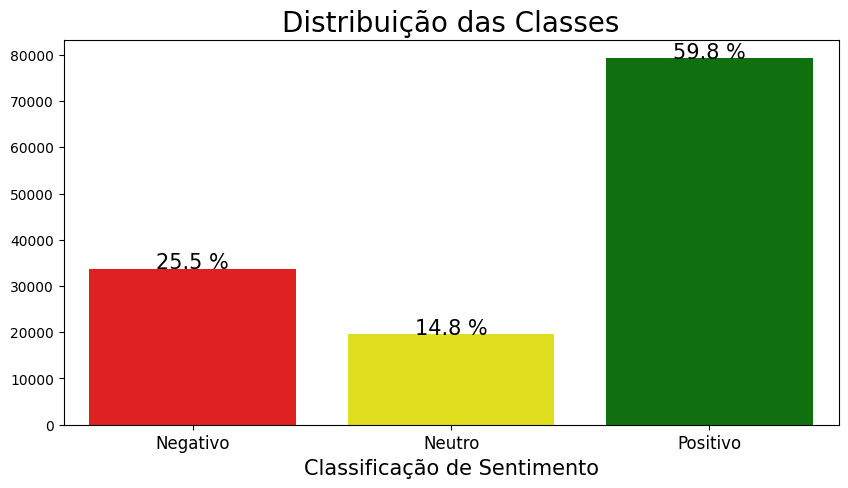

Distribuição Quantitativa:
 feeling
2    79316
0    33772
1    19567
Name: count, dtype: int64

Distribuição Percentual:
 feeling
2    0.597912
0    0.254585
1    0.147503
Name: proportion, dtype: float64


In [59]:
# Calcula a contagem e porcentagem das avaliações
rating_counts = combined_dataset['feeling'].value_counts().sort_index().tolist()
rating_p = combined_dataset['feeling'].value_counts(normalize=True).sort_index().mul(100).round(1).astype(str) + ' %'

palette = ['red', 'yellow', 'green']

# Plota o gráfico com as cores personalizadas e tamanho ajustado
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x='feeling', data=combined_dataset, hue='feeling', palette=palette, legend=False)
plt.xticks(fontsize=12, ticks=[0, 1, 2], labels=['Negativo', 'Neutro', 'Positivo'])
plt.title('Distribuição das Classes', fontsize=20)
ax.set_ylabel('')
ax.set_xlabel('Classificação de Sentimento', size=15)

# Adiciona os textos com as porcentagens
for i, v in enumerate(rating_counts):
    ax.text(i, v + 10, rating_p[i], ha='center', size=15, color='black')

plt.show()

print('Distribuição Quantitativa:\n',combined_dataset['feeling'].value_counts())
print('\nDistribuição Percentual:\n', combined_dataset['feeling'].value_counts(normalize=True))

## Treinamento e Validação do Modelo
Como já mencionado, estamos utilizando a biblioteca XGBoost para treinar um modelo capaz de classificar os sentimentos dos textos. Além disso, estamos aplicando uma técnica chamada **validação cruzada**, que é essencial para avaliar a capacidade de nosso modelo generalizar para novos dados.

* A **validação cruzada** é uma prática onde dividimos nossos dados em partes iguais, chamadas *folds*, para treinar e testar o modelo em diferentes conjuntos de dados. No nosso caso, estamos dividindo nossos dados em 5 folds. Uma parte dos dados é usada para treinar o modelo, enquanto outra parte é reservada para testar sua capacidade de generalização.

Durante o treinamento de cada *fold*, estamos considerando o desbalanceamento entre as classes ao atribuir pesos diferentes aos exemplos. Isso é importante porque algumas classes podem ter menos exemplos do que outras (no nosso caso, a classe 'neutro'), o que pode afetar a capacidade do modelo de aprender efetivamente a distinção entre elas. Portanto, estamos ajustando os pesos de cada exemplo durante o treinamento para garantir que o modelo dê mais importância às classes menos representadas.

In [60]:
# Cria uma instância do modelo XGBoost
xgboost = xgb.XGBClassifier()

# Especifica o número de folds para a validação cruzada
num_folds = 5

#  Cria um objeto StratifiedKFold para garantir que as classes estejam balanceadas em cada divisão
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lista para armazenar as pontuações de acurácia de cada divisão (fold)
accuracy_scores = []

# Realiza a validação cruzada
for train_index, test_index in kfold.split(X_ngrams, Y):
    # Separa os dados em conjuntos de treino e teste para esta divisão
    X_train, X_test = X_ngrams[train_index], X_ngrams[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Calcula os pesos de amostra com base nas classes
    class_weights = np.zeros(len(Y_train))
    class_counts = np.bincount(Y_train)
    for i in range(len(class_counts)):
        class_weights[Y_train == i] = len(Y_train) / class_counts[i]
    
    # Treina o modelo XGBoost com pesos de amostra
    xgboost.fit(X_train, Y_train, sample_weight=class_weights)

    # Avalia o modelo com os dados de teste e armazenar a acurácia
    accuracy = xgboost.score(X_test, Y_test)
    accuracy_scores.append(accuracy)

## Resultados

### Acurácia
Calculamos a média e o desvio padrão das pontuações de acurácia obtidas durante a validação cruzada. A média nos dá uma ideia geral do desempenho médio do nosso modelo, enquanto o desvio padrão indica o quanto as pontuações variam em relação à média. Isso nos ajuda a entender a consistência do desempenho do modelo em diferentes divisões dos dados. Por exemplo, se o desvio padrão for baixo, significa que as pontuações são consistentes e confiáveis.
Essas informações são úteis para avaliar a qualidade do modelo e entender como ele se comporta em diferentes conjuntos de dados de teste.

In [61]:
# Calcula a média e o desvio padrão das pontuações de acurácia obtidas da validação cruzada
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

# Exibe os resultados da validação cruzada
print("Acurácia média:", mean_accuracy)
print("Desvio padrão da acurácia:", std_accuracy)

Acurácia média: 0.7365798499868079
Desvio padrão da acurácia: 0.0020741291234523704


### Previsão das classes
Neste passo, estamos usando o modelo treinado para prever as classes (negativo, neutro ou positivo) dos comentários em um conjunto de dados separado que não foi usado durante o treinamento, chamado de conjunto de teste. Em seguida, criamos uma tabela que compara as previsões feitas pelo modelo com as classes reais dos comentários. Isso nos ajuda a entender quão preciso o modelo é em identificar os sentimentos dos comentários.

In [62]:
# Faz previsões para os dados de teste
Y_pred = xgboost.predict(X_test)

# Cria um DataFrame (tabela com os dados) para comparar as previsões com as classes reais de "feeling"

df_results = pd.DataFrame({'Feeling_Predicted': Y_pred, 'Feeling_True': Y_test})
# Substitui os valores numéricos pelos seus equivalentes em texto
df_results['Feeling_Predicted'] = df_results['Feeling_Predicted'].replace({0: 'negativo', 1: 'neutro', 2: 'positivo'})
df_results['Feeling_True'] = df_results['Feeling_True'].replace({0: 'negativo', 1: 'neutro', 2: 'positivo'})

# Mostra os resultados dos 10 primeiros
print("\nResultados de 'feeling' após o treinamento do modelo:")
print(tabulate(df_results.head(10), headers='keys', tablefmt='pipe'))


Resultados de 'feeling' após o treinamento do modelo:
|    | Feeling_Predicted   | Feeling_True   |
|---:|:--------------------|:---------------|
|  0 | negativo            | positivo       |
|  1 | positivo            | positivo       |
|  2 | positivo            | positivo       |
|  3 | positivo            | neutro         |
|  4 | positivo            | positivo       |
|  5 | negativo            | negativo       |
|  6 | neutro              | negativo       |
|  7 | positivo            | positivo       |
|  8 | positivo            | positivo       |
|  9 | positivo            | positivo       |


### Matriz de Confusão
É uma tabela que mostra a performance de um modelo de classificação. Cada linha representa as instâncias em uma classe real, enquanto cada coluna representa as instâncias em uma classe prevista pelo modelo. Os elementos na diagonal principal da matriz representam as previsões corretas, enquanto os elementos fora da diagonal principal são erros de classificação. Essa visualização ajuda a entender como o modelo está performando em cada classe.

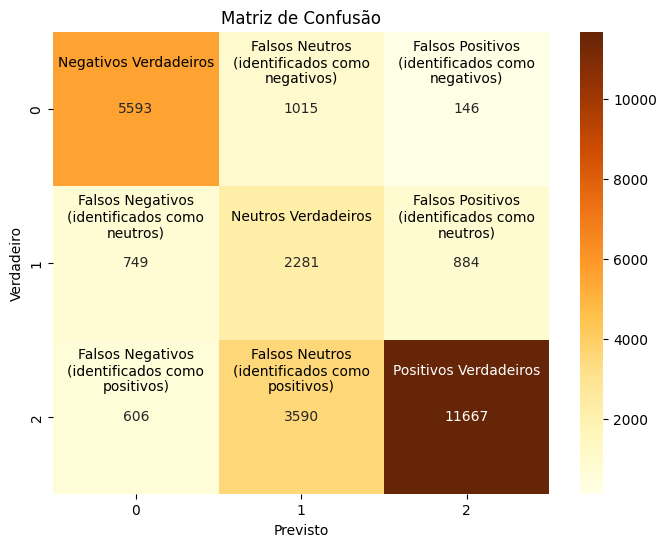

In [64]:
cm = confusion_matrix(Y_pred, Y_test)

# Plot da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, cmap='YlOrBr', fmt='g')

# Adicionando legenda
plt.text(0.5, 0.2, 'Negativos Verdadeiros', color='black', ha='center', va='center')
plt.text(1.5, 0.2, 'Falsos Neutros\n(identificados como\nnegativos)', color='black', ha='center', va='center')
plt.text(2.5, 0.2, 'Falsos Positivos\n(identificados como\nnegativos)', color='black', ha='center', va='center')

plt.text(0.5, 1.2, 'Falsos Negativos\n(identificados como\nneutros)', color='black', ha='center', va='center')
plt.text(1.5, 1.2, 'Neutros Verdadeiros', color='black', ha='center', va='center')
plt.text(2.5, 1.2, 'Falsos Positivos\n(identificados como\nneutros)', color='black', ha='center', va='center')

plt.text(0.5, 2.2, 'Falsos Negativos\n(identificados como\npositivos)', color='black', ha='center', va='center')
plt.text(1.5, 2.2, 'Falsos Neutros\n(identificados como\npositivos)', color='black', ha='center', va='center')
plt.text(2.5, 2.2, 'Positivos Verdadeiros', color='white', ha='center', va='center')

# Definindo rótulos dos eixos
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')

plt.show()

### Avaliação de performance
Neste trecho, estamos calculando métricas de avaliação para cada classe do nosso modelo de análise de sentimentos. Essas métricas nos ajudam a entender como nosso modelo está performando para cada categoria (negativo, neutro e positivo).

* Precisão (Precision):mede a proporção de exemplos positivos previstos corretamente em relação a todos os exemplos previstos como positivos. Ou seja, indica a qualidade das previsões positivas do modelo.

* Recall (Sensibilidade): mede a capacidade do modelo de encontrar todos os exemplos positivos. É a proporção de exemplos positivos previstos corretamente em relação a todos os exemplos que são realmente positivos.

* F1-score: é a média harmônica da precisão e do recall. Ele fornece um equilíbrio entre precisão e recall, sendo uma métrica útil quando as classes estão desbalanceadas.

Essas métricas nos dão uma visão detalhada de como nosso modelo está se saindo para cada classe, permitindo ajustes e melhorias caso necessário.

In [65]:
# Calcula a precisão para cada classe
precision_negativo = precision_score(Y_test, Y_pred, average=None)[0]
precision_neutro = precision_score(Y_test, Y_pred, average=None)[1]
precision_positivo = precision_score(Y_test, Y_pred, average=None)[2]

# Calcula o recall para cada classe
recall_negativo = recall_score(Y_test, Y_pred, average=None)[0]
recall_neutro = recall_score(Y_test, Y_pred, average=None)[1]
recall_positivo = recall_score(Y_test, Y_pred, average=None)[2]

# Calcula o F1-score para cada classe
f1_negativo = f1_score(Y_test, Y_pred, average=None)[0]
f1_neutro = f1_score(Y_test, Y_pred, average=None)[1]
f1_positivo = f1_score(Y_test, Y_pred, average=None)[2]

# Exibe os resultados
print("Precisão para a classe Negativo:", precision_negativo)
print("Precisão para a classe Neutro:", precision_neutro)
print("Precisão para a classe Positivo:", precision_positivo)

print("\nRecall para a classe Negativo:", recall_negativo)
print("Recall para a classe Neutro:", recall_neutro)
print("Recall para a classe Positivo:", recall_positivo)

print("\nF1-score para a classe Negativo:", f1_negativo)
print("F1-score para a classe Neutro:", f1_neutro)
print("F1-score para a classe Positivo:", f1_positivo)


Precisão para a classe Negativo: 0.8049798503166379
Precisão para a classe Neutro: 0.3312518152773744
Precisão para a classe Positivo: 0.9188784752303694

Recall para a classe Negativo: 0.828101865561149
Recall para a classe Neutro: 0.5827797649463464
Recall para a classe Positivo: 0.7354850910924794

F1-score para a classe Negativo: 0.8163771712158809
F1-score para a classe Neutro: 0.4224074074074074
F1-score para a classe Positivo: 0.8170168067226891


### Curva de ROC
Aqui vamos calcular as pontuações de probabilidade previstas para cada classe usando o método *predict_proba*. Em seguida, ele calcula a **Curva ROC** (*Receiver Operating Characteristic*) e a **AUC-ROC** (*Area Under the Curve of ROC*) para cada classe. 

A **Curva ROC** é uma representação gráfica da taxa de verdadeiros positivos em relação à taxa de falsos positivos para diferentes valores de threshold de classificação. 

Já a **AUC-ROC** é uma medida da capacidade do modelo de distinguir entre as classes. 

O código utiliza essas métricas para plotar as Curvas ROC para cada classe, com uma legenda indicando a área sob cada curva e os nomes das classes. A linha pontilhada representa a linha de base, indicando um classificador aleatório.

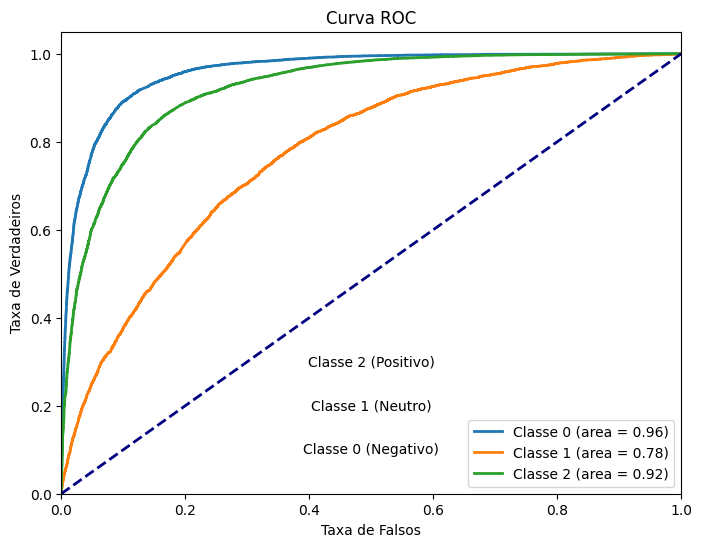

In [66]:
# Calcule as pontuações de probabilidade previstas para cada classe
y_scores = xgboost.predict_proba(X_test)

# Calcule a Curva ROC e a AUC-ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(xgboost.classes_)):
    fpr[i], tpr[i], _ = roc_curve(Y_test, y_scores[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot das Curvas ROC para cada classe com legenda
plt.figure(figsize=(8, 6))
for i in range(len(xgboost.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label='Classe {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos')
plt.ylabel('Taxa de Verdadeiros')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Adicionando legenda personalizada
class_legend = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}
for i in range(len(xgboost.classes_)):
    plt.text(0.5, 0.1 + i * 0.1, f"Classe {i} ({class_legend[i]})", color='black', ha='center', va='center')

plt.show()


## Exportação do modelo
Por fim, para viabilizar a utilização desse modelo no nosso projeto de dashboard (painel) de análise de sentimentos dos clientes, vamos exportar nosso modelo em um arquivo com a biblioteca Joblib, que será salvo no mesmo diretório deste notebook.

In [67]:
# Salva o modelo e o vetorizador em um único arquivo chamado 'modelo_xg_boost.joblib'
dump((xgboost, ngram_vectorizer), 'modelo_xg_boost.joblib')

['modelo_xg_boost.joblib']